# ReCoN Synthetic House: Validation Notebook

This notebook validates the step-by-step activation and messaging flow for the synthetic house example:
- Compile the house graph from YAML
- Generate a synthetic house image and compute terminal features
- Seed terminal activations and activate the root script
- Step the engine and observe requests (SUR), confirmations (SUB), and POR sequencing
- Assert that child scripts confirm and the root confirms within a few steps
- Visualize the scene and script activations

In [3]:
# Imports and setup
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

from recon_core import Engine
from recon_core.config import EngineConfig
from recon_core.compiler import compile_from_file
from recon_core.enums import State, UnitType
from perception.dataset import make_house_scene
from perception.terminals import terminals_from_image

# Utility
def summarize_units(g):
    return {uid: (u.kind.name, u.state.name, round(u.a, 3)) for uid, u in g.units.items()}

In [4]:
# Clean setup cell (robust path) - run this first if imports fail
import sys
if "/workspace" not in sys.path:
    sys.path.insert(0, "/workspace")
print("sys.path updated with /workspace")

sys.path updated with /workspace


In [7]:
# Compile graph from YAML
YAML_PATH = "scripts/house.yaml"

g = compile_from_file(YAML_PATH)
print("Units:", list(g.units.keys()))
print("Out-edges counts:", {k: len(v) for k, v in g.out_edges.items()})

Units: ['u_house', 'u_roof', 't_horz', 'u_body', 't_mean', 'u_door', 't_vert']
Out-edges counts: {'u_house': 3, 'u_roof': 3, 't_horz': 1, 'u_body': 3, 't_mean': 2, 'u_door': 3, 't_vert': 1}


Terminal features: {'t_mean': 0.107, 't_vert': 0.003, 't_horz': 0.005}


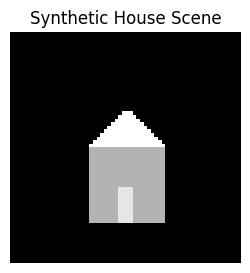

In [8]:
# Generate synthetic house image and compute terminal features
img = make_house_scene(size=64, noise=0.0)
terms = terminals_from_image(img)
print("Terminal features:", {k: round(v, 3) for k, v in terms.items()})

# Plot the scene
plt.figure(figsize=(3,3))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Synthetic House Scene')
plt.show()

In [9]:
# Seed terminal activations into graph and activate root script
for tid in ["t_mean", "t_vert", "t_horz"]:
    if tid in g.units:
        g.units[tid].a = float(terms.get(tid, 0.0))
        # Optional: mark requested if somewhat active (mirrors demo app seeding)
        g.units[tid].state = State.REQUESTED if g.units[tid].a > 0.1 else State.INACTIVE
        # Keep default terminal threshold (0.5)

# Activate the root script
root_id = 'u_house'
assert root_id in g.units, "Root unit u_house not found"
g.units[root_id].a = 1.0
g.units[root_id].state = State.ACTIVE

# Create engine
cfg = EngineConfig(deterministic_order=True)
engine = Engine(g, config=cfg)
print("Initial summary:")
print(json.dumps(summarize_units(g), indent=2))

Initial summary:
{
  "u_house": [
    "SCRIPT",
    "ACTIVE",
    1.0
  ],
  "u_roof": [
    "SCRIPT",
    "INACTIVE",
    0.0
  ],
  "t_horz": [
    "TERMINAL",
    "INACTIVE",
    0.005
  ],
  "u_body": [
    "SCRIPT",
    "INACTIVE",
    0.0
  ],
  "t_mean": [
    "TERMINAL",
    "REQUESTED",
    0.107
  ],
  "u_door": [
    "SCRIPT",
    "INACTIVE",
    0.0
  ],
  "t_vert": [
    "TERMINAL",
    "INACTIVE",
    0.003
  ]
}


In [10]:
# Step the engine and collect snapshots
snapshots = []
max_steps = 8
for step in range(max_steps):
    snap = engine.step(1)
    snapshots.append(snap)
    # Compact timeline printout for scripts
    scripts = [uid for uid, u in g.units.items() if u.kind == UnitType.SCRIPT]
    print(f"t={snap['t']}:", {uid: (g.units[uid].state.name, round(g.units[uid].a,2)) for uid in scripts})

print("\nStats:")
print(json.dumps(snapshots[-1]["stats"], indent=2))

t=1: {'u_house': ('ACTIVE', 1.0), 'u_roof': ('ACTIVE', 0.24), 'u_body': ('ACTIVE', 0.24), 'u_door': ('ACTIVE', 0.24)}
t=2: {'u_house': ('ACTIVE', 1.0), 'u_roof': ('ACTIVE', 0.88), 'u_body': ('ACTIVE', 0.88), 'u_door': ('ACTIVE', 1.0)}
t=3: {'u_house': ('CONFIRMED', 1.0), 'u_roof': ('CONFIRMED', 1.0), 'u_body': ('CONFIRMED', 1.0), 'u_door': ('CONFIRMED', 1.0)}
t=4: {'u_house': ('CONFIRMED', 1.0), 'u_roof': ('CONFIRMED', 1.0), 'u_body': ('CONFIRMED', 1.0), 'u_door': ('CONFIRMED', 1.0)}
t=5: {'u_house': ('CONFIRMED', 1.0), 'u_roof': ('CONFIRMED', 1.0), 'u_body': ('CONFIRMED', 1.0), 'u_door': ('CONFIRMED', 1.0)}
t=6: {'u_house': ('CONFIRMED', 1.0), 'u_roof': ('CONFIRMED', 1.0), 'u_body': ('CONFIRMED', 1.0), 'u_door': ('CONFIRMED', 1.0)}
t=7: {'u_house': ('CONFIRMED', 1.0), 'u_roof': ('CONFIRMED', 1.0), 'u_body': ('CONFIRMED', 1.0), 'u_door': ('CONFIRMED', 1.0)}
t=8: {'u_house': ('CONFIRMED', 1.0), 'u_roof': ('CONFIRMED', 1.0), 'u_body': ('CONFIRMED', 1.0), 'u_door': ('CONFIRMED', 1.0)}

St

In [11]:
# Assertions: child scripts and root should confirm within a few steps
stats = snapshots[-1]['stats']
first_conf = stats.get('first_confirm_step', {})

required_scripts = ['u_roof', 'u_body', 'u_door', 'u_house']
for rid in required_scripts:
    assert rid in first_conf, f"{rid} did not confirm"
    assert first_conf[rid] <= max_steps, f"{rid} confirmed too late: {first_conf[rid]}"

# Basic POR ordering expectation: roof no later than body, body no later than door
assert first_conf['u_roof'] <= first_conf['u_body'] + 1e-9
assert first_conf['u_body'] <= first_conf['u_door'] + 1e-9

# Ensure terminals were requested (SUR count > 0)
assert stats.get('terminal_request_count', 0) > 0, "No SUR requests to terminals were recorded"

print("All validation checks passed.")

All validation checks passed.


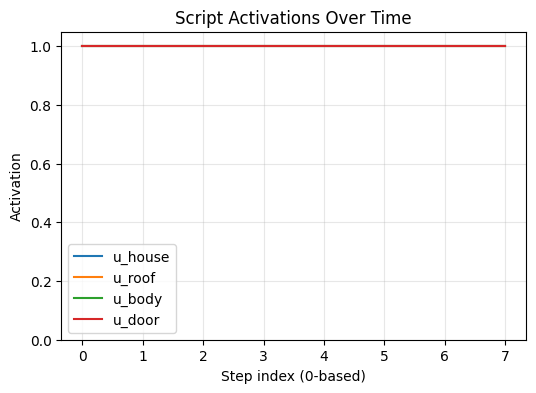

In [12]:
# Visualize script activations over time
script_ids = ['u_house', 'u_roof', 'u_body', 'u_door']
acts = {sid: [] for sid in script_ids}
for snap in snapshots:
    for sid in script_ids:
        acts[sid].append(g.units[sid].a)

plt.figure(figsize=(6,4))
for sid, series in acts.items():
    plt.plot(range(len(series)), series, label=sid)
plt.xlabel('Step index (0-based)')
plt.ylabel('Activation')
plt.title('Script Activations Over Time')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Results

- Child scripts receive SUR requests, terminals receive SUR and send CONFIRM when above threshold.
- `u_roof`, `u_body`, and `u_door` become `CONFIRMED`, then `u_house` becomes `CONFIRMED`.
- POR influences ordering (roof → body → door) as reflected by confirmation timing.
- The stats block shows `terminal_request_count` and first-step timings for `REQUESTED`, `ACTIVE`, `TRUE`, and `CONFIRMED` events.